# Exercise April, 20th 2022 - Determining the Morphology-Radial Distance relation and Morphology-Density relation

Student: Luigi Lucas de Carvalho Silva <br> 
UFRGS Card: 338979 <br>
Email: luigi.lcsilva@gmail.com

First of all, let us import some useful packages.

In [1]:
import numpy as np
import math
import matplotlib.ticker
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import glob
import scipy.constants

#Pandas was giving some annoying warnings, of type "SettingWithCopyWarning", which didn't influence the results. 
#The line below causes these warnings to be omitted.
#pd.options.mode.chained_assignment = None  #default='warn'

Let us also define some useful constants.

In [2]:
### Defining the Hubble constant and the deceleration parameter standard values.
H_0_LCDM = 73   #km_s_mpc
q_0_LCDM = -0.6 

### Defining the light velocity.
c_m_s = scipy.constants.c
c_km_s = c_m_s/1000

## PART 1 - Steps 1 to 8

### Step 1 - Reading the file

First of all, let us read the file containing the Coma Cluster sample using pandas. Source: https://articles.adsabs.harvard.edu/pdf/1995ApJS...97...77D.

In [3]:
### We can use pd.read_fwf to "Read a table of fixed-width formatted lines into DataFrame".
### Values will come as strings! Be careful!
df = pd.read_fwf('CatalogComaCluster.txt', colspecs='infer', skiprows=2, header=None)

### Defining the columns names.
df.columns = ['RAJ2000_h', 'RAJ2000_m', 'RAJ2000_s', 'DEJ2000_d', 'DEJ2000_m', 'DEJ2000_s', 'Num', 'CGCG',
              'NGC_IC', 'UGC', 'cz(km/s)', 'RA1950_h', 'RA1950_m', 'RA1950_s', 'DE1950_d', 'DE1950_m',
              'DE1950_s', 'B25.5(mag)', 'SB25.5(mag)', 'r_{e25.5}(arcsec)', 'Type', 'RAicrs_h', 'RAicrs_m',
              'RAicrs_s', 'DEicrs_d', 'DEicrs_m', 'RAicrs_s']

### Dropping the first row (this is used only to give the correct format) and reseting the index.
df = df.drop(0, axis=0)
df = df.reset_index(drop=True)

In [4]:
print(df.head())

  RAJ2000_h RAJ2000_m RAJ2000_s DEJ2000_d DEJ2000_m DEJ2000_s Num     CGCG  \
0        12        38   13.3486       +28        56    11.962   1  Z159037   
1        12        38   45.6863       +31        52    49.062   2      NaN   
2        12        38   48.0730       +32        05    30.292   3      NaN   
3        12        38   48.7993       +31        59    04.900   4      NaN   
4        12        39   00.5379       +28        18    53.017   5      NaN   

  NGC_IC    UGC  ... B25.5(mag) SB25.5(mag) r_{e25.5}(arcsec) Type RAicrs_h  \
0  N4585    NaN  ...      14.70       22.88               9.7    L       12   
1    NaN    NaN  ...      15.86       23.42               6.8    L       12   
2    NaN  U7812  ...      14.20       22.70              11.1    L       12   
3    NaN    NaN  ...      14.45       23.29               8.9    E       12   
4    NaN    NaN  ...      15.83       23.39               4.6    E       12   

  RAicrs_m RAicrs_s DEicrs_d DEicrs_m RAicrs_s  
0      

### Step 2 - Keeping only galaxies with measured redshifts

Next, I will keep in the dataframe only galaxies with measured redshifts.

In [5]:
### Dropping rows for which cz is "NaN".
df = df[df['cz(km/s)'].notna()]

### Reseting the index.
df = df.reset_index(drop=True)

In [6]:
print(df['cz(km/s)'].head())

0    7019
1    8041
2    6536
3    6574
4    7321
Name: cz(km/s), dtype: object


### Step 3 - Making a histogram with the distribution of galaxies as a function of radial velocity (km/s) and cutting the sample by selecting only galaxies within a range of radial velocities so as to minimize the contamination of the sample by galaxies which are not cluster members

First of all, let us make the histogram with the distribution of galaxies as a function of radial velocity (km/s).

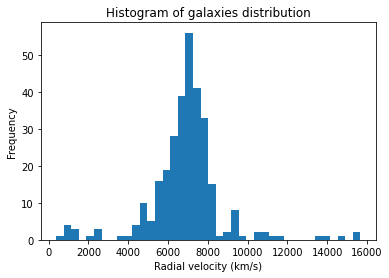

In [7]:
### First of all, it is necessary to turn the cz values into float numbers.
df['cz(km/s)'] = df['cz(km/s)'].astype(float)
x_nocut = df['cz(km/s)']

### Then, the histogram is made.
fig,ax = plt.subplots()
ax.hist(x_nocut, bins=40)
ax.set_xlabel("Radial velocity (km/s)")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of galaxies distribution")

plt.show()

Now, for the Coma Cluster, we have a redshift of $z_{coma} = 0.023156$, and the J2000 RA and DEC coordinates are $RA = 12h59m48.7s$ and $DEC = +27d58m50s$ (http://ned.ipac.caltech.edu/cgi-bin/nph-objsearch?objname=Abell+1656&extend=no).

We also have a velocity dispersion of $\sigma_r \approx 977 \frac{km}{s}$ (https://web.njit.edu/~gary/321/Lecture22.html).

So, based on the above, let us define some variables for the Coma Cluster.

In [8]:
### Coma Redshift
z_coma = 0.023156

### Coma Velocity
v_r_coma = z_coma*c_km_s #km/s

### Coma Velocity Dispersion
sigma_r_coma = 977 #km/s

### Coma RAJ2000 in Radians
coma_ra_h = 12
coma_ra_m = 59
coma_ra_s = 48.7

coma_ra_rad = ((coma_ra_h + coma_ra_m/60 + coma_ra_s/3600)*15)*np.pi/180

### Coma DEJ2000 in Radians
coma_de_d = 27
coma_de_m = 58
coma_de_s = 50

coma_de_rad = (coma_de_d + coma_de_m/60 + coma_de_s/3600)*np.pi/180

Now, let us cut the sample by selecting only galaxies within a range of radial velocities so as to minimize the contamination of the sample by galaxies which are not cluster members.

In [9]:
### Cut values for the sample.
n_sigma = 2  #Multiple of sigma_r_coma that we want to include around v_r_coma.
vel_min = v_r_coma - n_sigma*sigma_r_coma
vel_max = v_r_coma + n_sigma*sigma_r_coma

### Selecting the data according to the cut_value.
df = df[(df['cz(km/s)']>=vel_min) & (df['cz(km/s)']<=vel_max)]
x_cut = df['cz(km/s)']

### Showing the percentage of data kept after cutting.
print("Percentage of data kept after cutting: "+ str(len(x_cut)/len(x_nocut)))

Percentage of data kept after cutting: 0.8250825082508251


Now, let us make the new histogram.

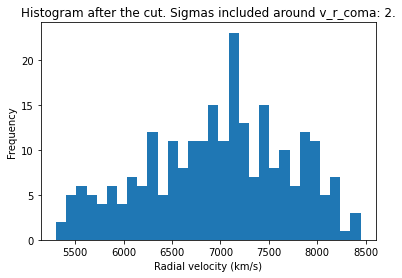

In [10]:
### Making the histogram.
fig,ax = plt.subplots()
ax.hist(x_cut, bins=30)
ax.set_xlabel("Radial velocity (km/s)")
ax.set_ylabel("Frequency")
ax.set_title("Histogram after the cut. Sigmas included around v_r_coma: %.f." %n_sigma)

plt.show()

### Step 4 - Plotting the on-sky distribution of galaxies (i.e., in RA, DEC) from the previous item, using different symbols for galaxies classified in the file as early-type (E) and late-type (L)

First of all, let us convert the RAJ2000 from (h:m:s) to radians.

In [11]:
### Turning things into float numbers.
df['RAJ2000_h'] = df['RAJ2000_h'].astype(float)
df['RAJ2000_m'] = df['RAJ2000_m'].astype(float)
df['RAJ2000_s'] = df['RAJ2000_s'].astype(float)

### Converting to radians.
df['RAJ2000_rad'] = ((df['RAJ2000_h'] + df['RAJ2000_m']/60 + df['RAJ2000_s']/3600)*15)*np.pi/180

print(df['RAJ2000_rad'].head())

0    3.312341
1    3.312656
2    3.313011
3    3.313072
4    3.313113
Name: RAJ2000_rad, dtype: float64


Now, let us convert the DEJ2000 from (d:m:s) to radians.

In [12]:
### Turning things into float numbers.
df['DEJ2000_d'] = df['DEJ2000_d'].astype(float)
df['DEJ2000_m'] = df['DEJ2000_m'].astype(float)
df['DEJ2000_s'] = df['DEJ2000_s'].astype(float)

### Converting to radians.
df['DEJ2000_rad'] = (df['DEJ2000_d'] + df['DEJ2000_m']/60 + df['DEJ2000_s']/3600)*np.pi/180

print(df['DEJ2000_rad'].head())

0    0.530695
1    0.484211
2    0.465618
3    0.487096
4    0.504470
Name: DEJ2000_rad, dtype: float64


Now, let us separate galaxies of early-type and late-type.

In [13]:
late_type_RA = df[df['Type'] == 'L']['RAJ2000_rad']
late_type_DEC = df[df['Type'] == 'L']['DEJ2000_rad']

early_type_RA = df[df['Type'] == 'E']['RAJ2000_rad']
early_type_DEC = df[df['Type'] == 'E']['DEJ2000_rad']

Now, let us make the plot.

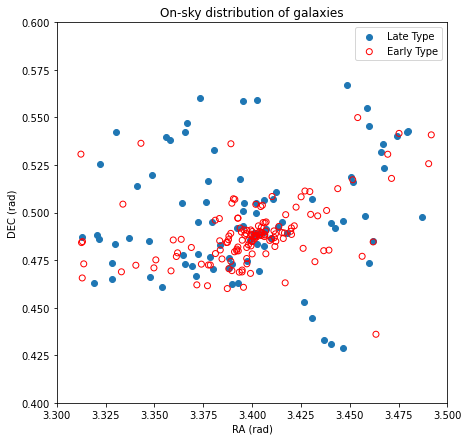

In [14]:
### Making a graph of the on-sky distribution of galaxies.
figure, axis = plt.subplots(figsize=(7,7))

axis.scatter(late_type_RA, late_type_DEC, label='Late Type')
axis.scatter(early_type_RA, early_type_DEC, label='Early Type', facecolors='none', edgecolors='r')

###### AXIS DEF ######
### Showing a legend.
axis.legend()

### Setting the axis labels.
axis.set_xlabel("RA (rad)")
axis.set_ylabel("DEC (rad)")

### Setting the title.
axis.set_title("On-sky distribution of galaxies")

### Setting axis limits.
axis.set_xlim(left=3.3, right=3.5)
axis.set_ylim(bottom=0.4, top=0.6)


plt.show()

### Step 5 - Computing the angular distance of each galaxy to the center of the Coma Cluster

In Step 3, I already showed the RA and DEC coordinates of the center of the Coma Cluster, and I also converted them to radians. So, I will just use them here.

The angular distance can be computed using the dot product of the unit vectors that point to the sources.

We can write a vector pointing to a certain source as $\vec{e}_i = cosDEC_i cosRA_i \vec{e}_x + cosDEC_i sinRA_i \vec{e}_y + sinDEC_i \vec{e}_z$.

So, the angular distance between the sources can be written as $\theta = arcos(\vec{e}_1 . \vec{e}_2)$.

Let us define a function to compute the angular distance between two sources.

In [15]:
def ang_dist(ra1, dec1, ra2, dec2):
    """
    Function for computing the angular distance between two sources. 
    Inputs must be in RADIANS.
    Returns the angular distance in RADIANS and in the closed interval [0, pi]. 
    """
    ang_dist = np.arccos(np.cos(dec1)*np.cos(dec2)*(np.cos(ra1)*np.cos(ra2) + np.sin(ra1)*np.sin(ra2)) +
                         np.sin(dec1)*np.sin(dec2))
    return ang_dist

Now, let us compute the angular distance of each galaxy to the center of the Coma Cluster and save it in the dataframe.

In [16]:
### Galaxies RA and DEC
ra1 = df['RAJ2000_rad'] 
dec1 = df['DEJ2000_rad']

### Coma Cluster center RA and DEC.
ra2 = coma_ra_rad
dec2 = coma_de_rad

df['ang_dist_to_center'] = ang_dist(ra1, dec1, ra2, dec2)

print(df['ang_dist_to_center'].head())

0    0.089412
1    0.079593
2    0.082739
3    0.079068
4    0.080286
Name: ang_dist_to_center, dtype: float64


### Step 6 - Converting the angular distances from the previous item to physical units of projected distance

First of all, let us discuss whether it matters if we use the Coma Cluster proper distance, luminosity distance, or angular diameter distance to the Local Group.

Proper distance is defined as $d_P(t_0) \approx \frac{c}{H_0} z \left ( 1 - \frac{1+q_0}{2} z \right )$, for $z \ll 1$ (see the Barbara Ryden book, Introduction to Cosmology; in second edition, this is the expression (6.30)).

Luminosity distance is defined as $d_L \approx \frac{c}{H_0} z \left ( 1 + \frac{1-q_0}{2} z \right )$, for nearly flat universe and for $z\ll1$ (see the Barbara Ryden book, Introduction to Cosmology; in second edition, this is the expression (6.31)).

Angular-diameter distance is defined as $d_A \approx \frac{c}{H_0} z \left ( 1 - \frac{3+q_0}{2} z \right )$, for $z \ll 1$ (see the Barbara Ryden book, Introduction to Cosmology; in second edition, this is the expression (6.38)).

So, as we can see, for very small z, as is the case of the Coma Cluster ($z=0.023156$), we expect those expressions to be approximately equal, with only very small divergences. Let us compute those distances for the Coma Cluster.

In [17]:
d_P_coma = (c_km_s/H_0_LCDM)*z_coma*(1-(1+q_0_LCDM)*z_coma/2) #Mpc
d_L_coma = (c_km_s/H_0_LCDM)*z_coma*(1+(1-q_0_LCDM)*z_coma/2) #Mpc
d_A_coma = (c_km_s/H_0_LCDM)*z_coma*(1-(3+q_0_LCDM)*z_coma/2) #Mpc

Now, let us inspect the fractional variations between them, that is, $\frac{d_1}{d_2} - 1$. This gives us the 
difference between the two distances in terms of a percentage change.

In [18]:
diff_P_L_coma = d_P_coma/d_L_coma - 1
diff_P_A_coma = d_P_coma/d_A_coma - 1
diff_L_A_coma = d_L_coma/d_A_coma - 1

print('Fractional variation - d_P_coma and d_L_coma: %f' % diff_P_L_coma)
print('Fractional variation - d_P_coma and d_A_coma: %f' % diff_P_A_coma)
print('Fractional variation - d_L_coma and d_A_coma: %f' % diff_L_A_coma)

Fractional variation - d_P_coma and d_L_coma: -0.022735
Fractional variation - d_P_coma and d_A_coma: 0.023818
Fractional variation - d_L_coma and d_A_coma: 0.047636


So, the difference between the distances is about 5%, at most, which is considerably small.

However, the angular-diameter distance $d_A$ can also be defined in terms of the proper length $l$ of a yardstick (this proper length must be constant, that is, the expansion of the universe must not 
considerably influence the proper length of the yardstick) and the measured angular distance $\delta \theta$. The relation is $d_A \equiv \frac{l}{\delta \theta}$. With this in mind, if we consider that the distances between galaxies in the Coma Cluster have not changed so much since the light that is reaching us now was emitted, angular-diameter distance $d_A$ may be a better type of distance to be used. 

With this consideration (constant proper length), the proper distances between the galaxies and the center would be calculated with $l = d_A\delta \theta$. This consideration might not be exactly true, but, anyway, the percentage change between two different types of distances is small, then it will not generate great divergences.

Finally, let us convert the angular distances from the previous item to physical units of projected distance and save them in the dataframe.

In [19]:
### Showing the maximum value of angular distance to the center, as computed before.
print('Maximum angular distance computed = '+str(df['ang_dist_to_center'].max()*180/np.pi)+'°')

Maximum angular distance computed = 5.367228073563763°


In [20]:
### As the maximum angular distance computed is small, we can use the small angle approximation.

### So, for the projected distance to the center, we have:
df['proj_dist_to_center'] = df['ang_dist_to_center']*d_A_coma #Mpc

print(df['proj_dist_to_center'].head())

0    8.266410
1    7.358644
2    7.649541
3    7.310059
4    7.422754
Name: proj_dist_to_center, dtype: float64


### Step 7 - Splitting the galaxies in bins of projected distance from the center of Coma and computing the fraction of early-type (E) and late-type (L) galaxies at each bin

Let us bin the data.

In [21]:
### Binning the data in relation to the project distance to the center.
nbins = 10 #Number of bins.

df['BINS'] = pd.cut(df['proj_dist_to_center'], nbins)

### Obtaining the bin size.
bin_size = df['BINS'][0].right - df['BINS'][0].left

print("Bin size = "+ str(bin_size)+" Mpc")

Bin size = 0.8579999999999997 Mpc


Now, let us group the data of each bin.

In [22]:
### Grouping the data of each bin.
bin_groups = df.groupby(df['BINS'])

### Obtaining the maximum, minimum and mean number of values in the bins.
max_number = bin_groups.size().max()
min_number = bin_groups.size().min()
mean_number = bin_groups.size().mean()

print("Galaxies in each bin: \n"+str(bin_groups.size())+"\n")
print("Maximum number of elements in a bin = "+ str(max_number))
print("Minimum number of elements in a bin = "+ str(min_number))
print("Mean number of elements by bin = "+ str(mean_number))

Galaxies in each bin: 
BINS
(0.0748, 0.941]    64
(0.941, 1.799]     48
(1.799, 2.657]     34
(2.657, 3.514]     27
(3.514, 4.372]      8
(4.372, 5.23]      18
(5.23, 6.087]      11
(6.087, 6.945]     17
(6.945, 7.803]     17
(7.803, 8.661]      6
dtype: int64

Maximum number of elements in a bin = 64
Minimum number of elements in a bin = 6
Mean number of elements by bin = 25.0


Now, let us compute the fraction of early-type (E) and late-type (L) galaxies in each bin. For doing this, I will divide the number of galaxies of a certain type in the bin by the total number of galaxies in the bin.

The uncertainties in the number of galaxies can be thought as Poisson fluctuations (the probability of finding a certain galaxy in a certain region of space is very small compared with the probability of not finding, so it is well modeled by a Poisson distribution). So, we have, for the uncertainty, $\sigma_{N_i} = \sqrt{N_i}$, for a certain number of galaxies $N_i$.

The math we will do for each galaxy type is as follows: $f_i = \frac{N_i}{N_T}$. So, for obtaining the uncertainty of the fractions, we must propagate the numbers uncertainties. We can do this by the square root of the derivatives formula (see John R. Taylor book, Introdução à Análise de Erros; in second edition, this is equation 3.47), $\sigma_{f_i} = \left(\left(\frac{\partial f_i}{\partial N_i}\right)^2 \sigma_{N_i}^2 + \left(\frac{\partial f_i}{\partial N_T}\right)^2 \sigma_{N_T}^2\right)^{\frac{1}{2}}$.

Applying this formula to our case, we have $\sigma_{f_i} = \left( \left ( \frac{\sigma_{N_i}}{N_T} \right )^2 + \left ( \frac{N_i \sigma_{N_T}}{N_T^2} \right )^2 \right)^{\frac{1}{2}}$.

Let us do it.

In [23]:
### Defining a list with the groups names.
groups_names = list(bin_groups.groups)

### Defining some arrays for saving the fractions, the errors and also the mid value of each bin.
frac_L = np.zeros(len(groups_names))
frac_E = np.zeros(len(groups_names))
frac_L_e = np.zeros(len(groups_names))
frac_E_e = np.zeros(len(groups_names))
mid_bin = np.zeros(len(groups_names))

### Making a loop, where I get each group (each bin) and compute the fractions, errors and mid value of each bin.
j=0
for i in groups_names:
    ### Getting group by group.                    
    group = bin_groups.get_group(i)
                    
    ### Computing the fractions.
    NL = len(group[group['Type']=='L'])
    NE = len(group[group['Type']=='E'])
    NT = len(group['Type'])
    frac_L[j] = NL/NT
    frac_E[j] = NE/NT
                    
    ### Computing the errors.
    sigma_NL = np.sqrt(NL)
    sigma_NE = np.sqrt(NE)
    sigma_NT = np.sqrt(NT)
                    
    frac_L_e[j] = np.sqrt((sigma_NL/NT)**2 + (NL*sigma_NT/NT**2)**2)
    frac_E_e[j] = np.sqrt((sigma_NE/NT)**2 + (NE*sigma_NT/NT**2)**2)                
                    
    ### Computing the middle of the bins.
    mid_bin[j] = (i.left + i.right)/2
                    
    j+=1

### Step 8 - Plotting the two fractions as a function of projected distance on the same figure

Now, let us make the plot.

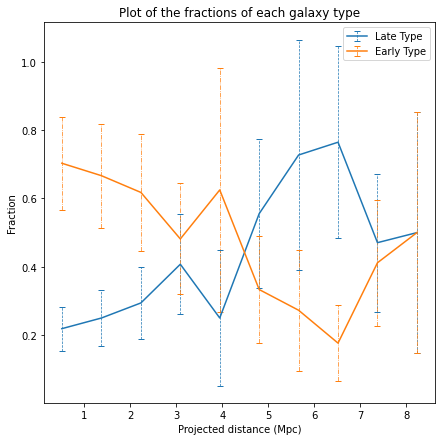

In [24]:
### Making the graph.
figure, axis = plt.subplots(figsize=(7,7))

eb1=axis.errorbar(mid_bin, frac_L, yerr=frac_L_e, capsize=3, elinewidth=0.7, label='Late Type')
eb1[-1][0].set_linestyle('--') 
eb2=axis.errorbar(mid_bin, frac_E, yerr=frac_E_e, capsize=3, elinewidth=0.7, label='Early Type')
eb2[-1][0].set_linestyle('-.')

###### AXIS DEF ######
### Showing a legend.
axis.legend()

### Setting the axis labels.
axis.set_xlabel("Projected distance (Mpc)")
axis.set_ylabel("Fraction")

### Setting the title.
axis.set_title("Plot of the fractions of each galaxy type")

### Setting axis limits.
#axis.set_xlim(left=3.3, right=3.5)
#axis.set_ylim(bottom=0.4, top=0.6)


plt.show()

So, as we can see, there are more early-type (E's and S0) galaxies near the center of the cluster than late-type (S's and SB's) galaxies. For regions further away from the center, it seems like we have a predominance of late-type galaxies. However, it is worth noting that there are more galaxies in the center than in the outskirts of the cluster, so we can conclude that the cluster probably have a higher number o early-type galaxies.

Let us check this affirmation.

In [25]:
early_type_num = len(df[df['Type'] == 'E']['Type'])
late_type_num = len(df[df['Type'] == 'L']['Type'])
total_num = len(df['Type'])

print('Fraction of early type galaxies in the sample (considering the ones with measured cz) = '
      +str(early_type_num/total_num))
print('Fraction of late type galaxies in the sample (considering the ones with measured cz) = '
      +str(late_type_num/total_num))

Fraction of early type galaxies in the sample (considering the ones with measured cz) = 0.552
Fraction of late type galaxies in the sample (considering the ones with measured cz) = 0.364


## PART 2 - Steps 9 to 12

### Step 9 - Computing, for each galaxy in the Coma cluster sample, the angular distance from the others, and converting these distances to projected physical distances using the distance to the cluster, as done before

First, I will reset the index of the dataframe.

In [26]:
df = df.reset_index()

print(df.head())

   index  RAJ2000_h  RAJ2000_m  RAJ2000_s  DEJ2000_d  DEJ2000_m  DEJ2000_s  \
0      0       12.0       39.0     7.9576       30.0       24.0     23.619   
1      1       12.0       39.0    12.2889       27.0       44.0     35.754   
2      2       12.0       39.0    17.1672       26.0       40.0     40.506   
3      3       12.0       39.0    18.0035       27.0       54.0     30.824   
4      4       12.0       39.0    18.5729       28.0       54.0     14.437   

  Num     CGCG NGC_IC  ... RAicrs_m RAicrs_s DEicrs_d DEicrs_m RAicrs_s  \
0   6      NaN    NaN  ...       39    07.96      +30       24     23.6   
1   8  Z159042    NaN  ...       39    12.29      +27       44     35.8   
2   9  Z159041  I3618  ...       39    17.17      +26       40     40.5   
3  10  Z159044  I3620  ...       39    18.00      +27       54     30.8   
4  11  Z159045    NaN  ...       39    18.57      +28       54     14.4   

  RAJ2000_rad DEJ2000_rad ang_dist_to_center proj_dist_to_center  \
0    3.31234

Now, I will compute the angular distance of each one of the galaxies to the others. In the loop, I will also compute the projected physical distances (Mpc) and save them in the dataframe.

In [27]:
for row in range(0, len(df)):
    for col in range(0, len(df)):
        col_name = 'd_to_'+str(col)
        
        ra1 = df.loc[row, 'RAJ2000_rad'] 
        dec1 = df.loc[row, 'DEJ2000_rad']
        
        ra2 = df.loc[col, 'RAJ2000_rad']
        dec2 = df.loc[col, 'DEJ2000_rad']
        
        angular_distance = ang_dist(ra1, dec1, ra2, dec2)
        
        df.loc[row, col_name] = angular_distance*d_A_coma

/tmp/ipykernel_78169/2907455219.py:7: RuntimeWarning: invalid value encountered in arccos
  ang_dist = np.arccos(np.cos(dec1)*np.cos(dec2)*(np.cos(ra1)*np.cos(ra2) + np.sin(ra1)*np.sin(ra2)) +


In [28]:
print(df.head())

   index  RAJ2000_h  RAJ2000_m  RAJ2000_s  DEJ2000_d  DEJ2000_m  DEJ2000_s  \
0      0       12.0       39.0     7.9576       30.0       24.0     23.619   
1      1       12.0       39.0    12.2889       27.0       44.0     35.754   
2      2       12.0       39.0    17.1672       26.0       40.0     40.506   
3      3       12.0       39.0    18.0035       27.0       54.0     30.824   
4      4       12.0       39.0    18.5729       28.0       54.0     14.437   

  Num     CGCG NGC_IC  ...   d_to_240   d_to_241   d_to_242   d_to_243  \
0   6      NaN    NaN  ...  12.523239  12.779151  12.888222  12.931366   
1   8  Z159042    NaN  ...  13.371128  13.238428  13.995560  13.901379   
2   9  Z159041  I3618  ...  14.048801  13.777634  14.750198  14.609599   
3  10  Z159044  I3620  ...  13.246494  13.135538  13.858293  13.771396   
4  11  Z159045    NaN  ...  12.787040  12.818571  13.310303  13.272521   

    d_to_244   d_to_245   d_to_246   d_to_247   d_to_248   d_to_249  
0  12.981476  13

### Step 10 - Choosing a small integer N, 2 <= N <= 6, and computing, for each galaxy, the local surface density of neighbours

Now, for each galaxy, I will get the N (some integer between 2 and 6) nearest neighbors. Then, I will compute, for each galaxy, the local surface density of neighbors, given by the relation $n = \frac{N}{\pi R^2(N)}$, where $R(N)$ is the projected distance of the N-th galaxy. 

In [29]:
### Numbers of neighbors I will get.
N = 5
 
for row in range(0, len(df)):
    ### Sorting the distance values in ascending order and getting the N nearest neighbors.
    ### The first value (position 0) is 0, because it is the distance of the galaxy to itself.
    R_N = df.loc[row, 'd_to_0':'d_to_249'].sort_values()[1:N+1].max()
    
    ### Computing the local surface density of neighbors and saving in the dataframe.
    df.loc[row, 'surf_dens_neighbors'] = N/(np.pi*R_N**2)

In [30]:
print(df.head())

   index  RAJ2000_h  RAJ2000_m  RAJ2000_s  DEJ2000_d  DEJ2000_m  DEJ2000_s  \
0      0       12.0       39.0     7.9576       30.0       24.0     23.619   
1      1       12.0       39.0    12.2889       27.0       44.0     35.754   
2      2       12.0       39.0    17.1672       26.0       40.0     40.506   
3      3       12.0       39.0    18.0035       27.0       54.0     30.824   
4      4       12.0       39.0    18.5729       28.0       54.0     14.437   

  Num     CGCG NGC_IC  ...   d_to_241   d_to_242   d_to_243   d_to_244  \
0   6      NaN    NaN  ...  12.779151  12.888222  12.931366  12.981476   
1   8  Z159042    NaN  ...  13.238428  13.995560  13.901379  14.123561   
2   9  Z159041  I3618  ...  13.777634  14.750198  14.609599  14.887528   
3  10  Z159044  I3620  ...  13.135538  13.858293  13.771396  13.984721   
4  11  Z159045    NaN  ...  12.818571  13.310303  13.272521  13.425314   

    d_to_245   d_to_246   d_to_247   d_to_248   d_to_249 surf_dens_neighbors  
0  13.2

### Step 11 - Examining the values of the surface densities from the previous item and defining an array of density values that covers the range of values for the sample

First, I will examine the values of the surface densities from the previous item, given in units of $\frac{\#galaxies}{Mpc^2}$. 

In [31]:
surf_dens_min = df['surf_dens_neighbors'].min()
surf_dens_max = df['surf_dens_neighbors'].max()

print('Minimum surface density = '+str(surf_dens_min))
print('Maximum surface density = '+str(surf_dens_max))

Minimum surface density = 0.1322279685107934
Maximum surface density = 234.08378850832315


Now, I will define an array of density values that covers the range of values for the sample. I will use a log scale for the array.

In [32]:
### Consider 10^x = value. I will get x (exponent of the corresponding power of 10) for value being surf_dens_min 
### and surf_dens_max.
x_min = np.log10(surf_dens_min*0.999)    # The multiplying factors are for us to be sure to include the min 
x_max = np.log10(surf_dens_max*1.001)    # and the max values.

### Defining n_bins values in a log scale from surf_dens_min to surf_dens_max.
n_bins = 10
bins = np.logspace(x_min, x_max, n_bins)

print(bins)

[1.32095741e-01 3.03304984e-01 6.96418470e-01 1.59904621e+00
 3.67156945e+00 8.43028935e+00 1.93567845e+01 4.44451062e+01
 1.02050393e+02 2.34317872e+02]


### Step 12 - Redoing items 7 and 8, but now splitting galaxies in bins of surface density and determining the fractions of E e L galaxies as a function of this quantity.

Let us bin the data using the previous array (the log-scale array).

In [33]:
df['BINS_SURF'] = pd.cut(df['surf_dens_neighbors'], bins)

Now, let us group the data of each bin.

In [34]:
### Grouping the data of each bin.
bin_groups = df.groupby(df['BINS_SURF'])

### Obtaining the maximum, minimum and mean number of values in the bins.
max_number = bin_groups.size().max()
min_number = bin_groups.size().min()
mean_number = bin_groups.size().mean()

print("Galaxies in each bin: \n"+str(bin_groups.size())+"\n")
print("Maximum number of elements in a bin = "+ str(max_number))
print("Minimum number of elements in a bin = "+ str(min_number))
print("Mean number of elements by bin = "+ str(mean_number))

Galaxies in each bin: 
BINS_SURF
(0.132, 0.303]        9
(0.303, 0.696]       26
(0.696, 1.599]       40
(1.599, 3.672]       40
(3.672, 8.43]        48
(8.43, 19.357]       32
(19.357, 44.445]     25
(44.445, 102.05]     23
(102.05, 234.318]     7
dtype: int64

Maximum number of elements in a bin = 48
Minimum number of elements in a bin = 7
Mean number of elements by bin = 27.77777777777778


Now, let us compute the fraction of early-type (E) and late-type (L) galaxies in each bin, and also the errors.

In [35]:
### Defining a list with the groups names.
groups_names = list(bin_groups.groups)

### Defining some arrays for saving the fractions, the errors and also the mid value of each bin.
frac_L = np.zeros(len(groups_names))
frac_E = np.zeros(len(groups_names))
frac_L_e = np.zeros(len(groups_names))
frac_E_e = np.zeros(len(groups_names))
mid_bin = np.zeros(len(groups_names))

### Making a loop, where I get each group (each bin) and compute the fractions, errors and mid value of each bin.
j=0
for i in groups_names:
    ### Getting group by group.                    
    group = bin_groups.get_group(i)
                    
    ### Computing the fractions.
    NL = len(group[group['Type']=='L'])
    NE = len(group[group['Type']=='E'])
    NT = len(group['Type'])
    frac_L[j] = NL/NT
    frac_E[j] = NE/NT
                    
    ### Computing the errors.
    sigma_NL = np.sqrt(NL)
    sigma_NE = np.sqrt(NE)
    sigma_NT = np.sqrt(NT)
                    
    frac_L_e[j] = np.sqrt((sigma_NL/NT)**2 + (NL*sigma_NT/NT**2)**2)
    frac_E_e[j] = np.sqrt((sigma_NE/NT)**2 + (NE*sigma_NT/NT**2)**2)                
                    
    ### Computing the middle of the bins.
    mid_bin[j] = (i.left + i.right)/2
                    
    j+=1

Now, let us make the plot.

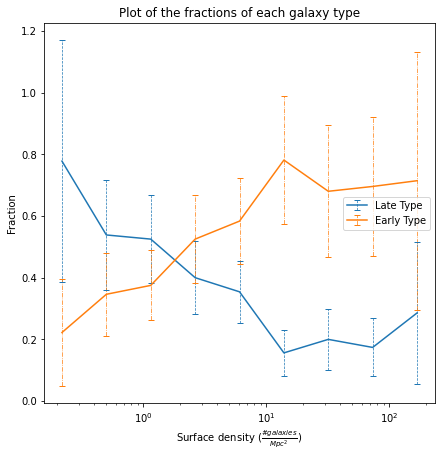

In [36]:
### Making the graph.
figure, axis = plt.subplots(figsize=(7,7))

eb1=axis.errorbar(mid_bin, frac_L, yerr=frac_L_e, capsize=3, elinewidth=0.7, label='Late Type')
eb1[-1][0].set_linestyle('--') 
eb2=axis.errorbar(mid_bin, frac_E, yerr=frac_E_e, capsize=3, elinewidth=0.7, label='Early Type')
eb2[-1][0].set_linestyle('-.')

###### AXIS DEF ######
### Showing a legend.
axis.legend()

### Setting the axis labels.
axis.set_xlabel("Surface density ($\\frac{\# galaxies}{Mpc^2}$)")
axis.set_ylabel("Fraction")

### Setting the title.
axis.set_title("Plot of the fractions of each galaxy type")

### Setting axis scale.
axis.set_xscale('log')


plt.show()

So, as we can see, there are more early-type (E's and S0) galaxies in regions of high surface densities than late-type (S's and SB's) galaxies. This is in agreement with the discussion for the morphology-radius relation, since regions of high surface densities are regions next to the center.

For regions of low surface density (further away from the center), it seems like we have a predominance of late-type galaxies; this is again in agreement with the discussion for the morphology-radius relation.